# ART Adversarial Patch attack

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import warnings
warnings.filterwarnings('ignore')

# Install Imagenet stubs to have some image examples
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs

import random
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

from art.classifiers import TensorFlowClassifier
from art.attacks import AdversarialPatch

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-k481919b
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-k481919b
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp36-none-any.whl size=794842 sha256=74ee2a0343b93cf9cbaca30793f15304d8340061a21d636d1b558df66e924b55
  Stored in directory: /tmp/pip-ephem-wheel-cache-yyfmyq0k/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs
You should consider upgrading via the 'pip install --upgrade pip' command.


# Settings

In [2]:
target_name = 'toaster'
image_shape = (224, 224, 3)
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

# Model definition

In [3]:
_image_input = tf.keras.Input(shape=image_shape)
_target_ys = tf.placeholder(tf.float32, shape=(None, 1000))
model = tf.keras.applications.resnet50.ResNet50(input_tensor=_image_input, weights='imagenet')
_logits = model.outputs[0].op.inputs[0]
# target_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits))
target_loss = tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits)

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowClassifier(clip_values=(0, 255), input_ph=_image_input, labels_ph=_target_ys, output=_logits,
                   sess=sess, loss=target_loss, preprocessing=([mean_b, mean_g, mean_r], 1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.




# Imagenet training images

In [4]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32)
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

# Adversarial patch generation

In [5]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)

label = name_to_label(target_name)
y_one_hot = np.zeros(1000)
y_one_hot[label] = 1.0
# y_target = np.tile(y_one_hot, (batch_size, 1))
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

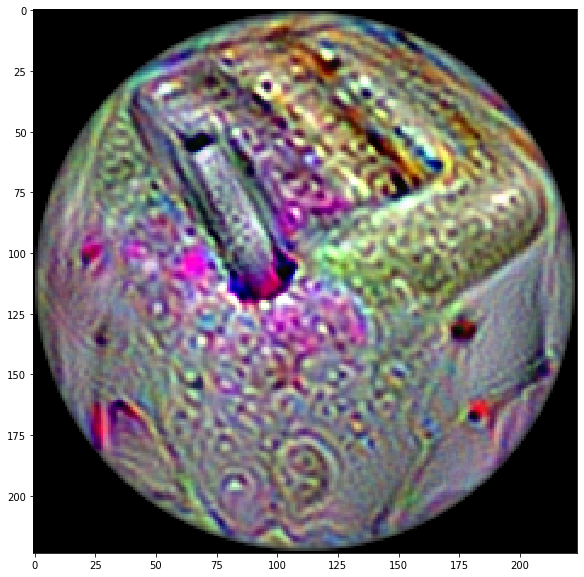

In [6]:
plt.imshow((patch[:, :, ::-1] * patch_mask).astype(np.uint8))

# Evaluation

In [7]:
patched_images = ap.apply_patch(images, scale=0.5)[:, :, :, ::-1]

In [8]:
def predict_model(model, image):
    plt.imshow(image.astype(np.uint8))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

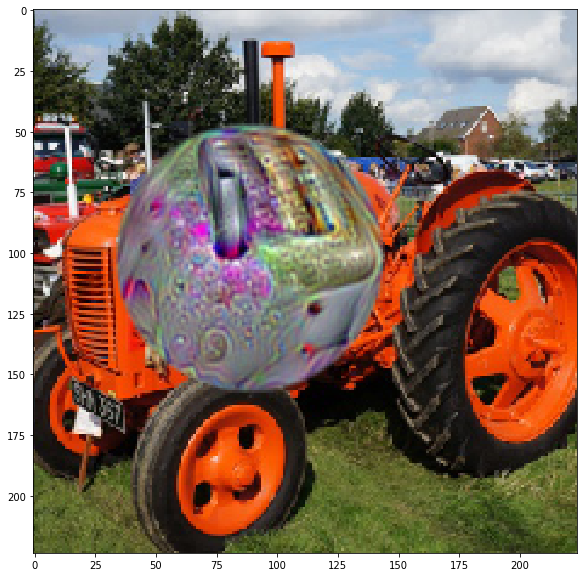

Predictions:
toaster       0.52
tractor       0.42
piggy_bank    0.04
plow          0.00
parking_meter 0.00


In [9]:
predict_model(model, patched_images[0, :, :, :])

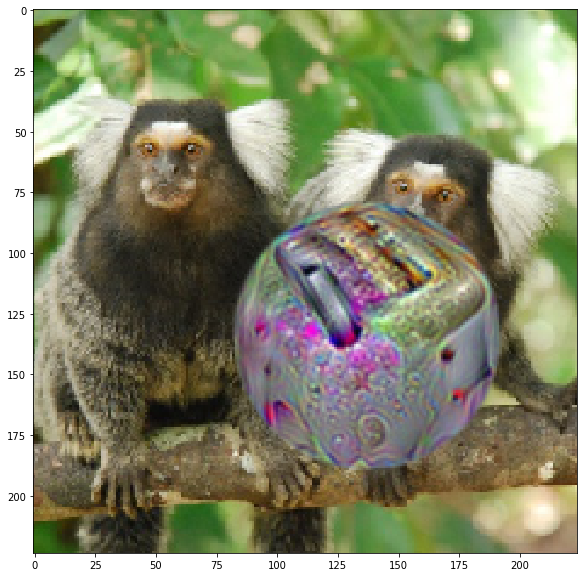

Predictions:
toaster    0.47
titi       0.22
marmoset   0.11
piggy_bank 0.05
capuchin   0.03


In [10]:
predict_model(model, patched_images[1, :, :, :])

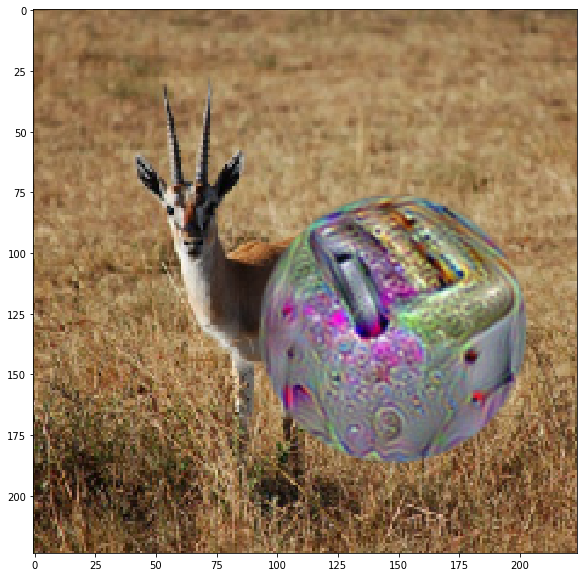

Predictions:
toaster          1.00
piggy_bank       0.00
pencil_sharpener 0.00
teapot           0.00
gazelle          0.00


In [11]:
predict_model(model, patched_images[2, :, :, :])